##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TFLite colab.


## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.7.0
Hub version: 0.12.0


GPU is available


## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [3]:
model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

    16384/228813984 [..............................] - ETA: 1s

  9478144/228813984 [>.............................] - ETA: 1s

 20561920/228813984 [=>............................] - ETA: 1s

 30334976/228813984 [==>...........................] - ETA: 0s

 41918464/228813984 [====>.........................] - ETA: 0s

 53477376/228813984 [======>.......................] - ETA: 0s

 64823296/228813984 [=======>......................] - ETA: 0s

 76021760/228813984 [========>.....................] - ETA: 0s

 87343104/228813984 [==========>...................] - ETA: 0s

 99123200/228813984 [===========>..................] - ETA: 0s

110755840/228813984 [=============>................] - ETA: 0s

122298368/228813984 [===============>..............] - ETA: 0s

133709824/228813984 [================>.............] - ETA: 0s

144924672/228813984 [==================>...........] - ETA: 0s



155090944/228813984 [===================>..........] - ETA: 0s

165527552/228813984 [====================>.........] - ETA: 0s

176168960/228813984 [======================>.......] - ETA: 0s

187056128/228813984 [=======================>......] - ETA: 0s

197632000/228813984 [========================>.....] - ETA: 0s

208551936/228813984 [==========================>...] - ETA: 0s

219586560/228813984 [===========================>..] - ETA: 0s

228818944/228813984 [==============================] - 1s 0us/step


228827136/228813984 [==============================] - 1s 0us/step


In [5]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [6]:
do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 207,622,237
Trainable params: 6,405
Non-trainable params: 207,615,832
_________________________________________________________________


## Training the model

In [8]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [9]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5


  1/183 [..............................] - ETA: 1:43:58 - loss: 3.4618 - accuracy: 0.1875

  2/183 [..............................] - ETA: 1:14 - loss: 2.8042 - accuracy: 0.1875   

  3/183 [..............................] - ETA: 1:13 - loss: 2.6657 - accuracy: 0.2083

  4/183 [..............................] - ETA: 1:13 - loss: 2.4254 - accuracy: 0.3125

  5/183 [..............................] - ETA: 1:13 - loss: 2.3262 - accuracy: 0.3250

  6/183 [..............................] - ETA: 1:12 - loss: 2.1096 - accuracy: 0.3958

  7/183 [>.............................] - ETA: 1:12 - loss: 2.0784 - accuracy: 0.4375

  8/183 [>.............................] - ETA: 1:11 - loss: 1.9548 - accuracy: 0.4766

  9/183 [>.............................] - ETA: 1:11 - loss: 1.8707 - accuracy: 0.5208

 10/183 [>.............................] - ETA: 1:10 - loss: 1.7636 - accuracy: 0.5625

 11/183 [>.............................] - ETA: 1:10 - loss: 1.6928 - accuracy: 0.5852

 12/183 [>.............................] - ETA: 1:09 - loss: 1.6403 - accuracy: 0.5990

 13/183 [=>............................] - ETA: 1:09 - loss: 1.5940 - accuracy: 0.6202

 14/183 [=>............................] - ETA: 1:09 - loss: 1.5790 - accuracy: 0.6295

 15/183 [=>............................] - ETA: 1:08 - loss: 1.5414 - accuracy: 0.6500

 16/183 [=>............................] - ETA: 1:08 - loss: 1.5044 - accuracy: 0.6680

 17/183 [=>............................] - ETA: 1:08 - loss: 1.4772 - accuracy: 0.6801

 18/183 [=>............................] - ETA: 1:07 - loss: 1.4415 - accuracy: 0.6979

 19/183 [==>...........................] - ETA: 1:07 - loss: 1.4190 - accuracy: 0.7138

 20/183 [==>...........................] - ETA: 1:06 - loss: 1.4017 - accuracy: 0.7250

 21/183 [==>...........................] - ETA: 1:06 - loss: 1.3802 - accuracy: 0.7381

 22/183 [==>...........................] - ETA: 1:06 - loss: 1.3665 - accuracy: 0.7472

 23/183 [==>...........................] - ETA: 1:05 - loss: 1.3684 - accuracy: 0.7473

 24/183 [==>...........................] - ETA: 1:05 - loss: 1.3490 - accuracy: 0.7578

 25/183 [===>..........................] - ETA: 1:04 - loss: 1.3438 - accuracy: 0.7650

 26/183 [===>..........................] - ETA: 1:04 - loss: 1.3429 - accuracy: 0.7692

 27/183 [===>..........................] - ETA: 1:03 - loss: 1.3441 - accuracy: 0.7731

 28/183 [===>..........................] - ETA: 1:03 - loss: 1.3305 - accuracy: 0.7812

 29/183 [===>..........................] - ETA: 1:03 - loss: 1.3223 - accuracy: 0.7866

 30/183 [===>..........................] - ETA: 1:02 - loss: 1.3093 - accuracy: 0.7937

 31/183 [====>.........................] - ETA: 1:02 - loss: 1.3006 - accuracy: 0.8004

 32/183 [====>.........................] - ETA: 1:01 - loss: 1.2873 - accuracy: 0.8066

 33/183 [====>.........................] - ETA: 1:01 - loss: 1.2881 - accuracy: 0.8106

 34/183 [====>.........................] - ETA: 1:01 - loss: 1.2833 - accuracy: 0.8143

 35/183 [====>.........................] - ETA: 1:00 - loss: 1.2746 - accuracy: 0.8161

 36/183 [====>.........................] - ETA: 1:00 - loss: 1.2624 - accuracy: 0.8212

 37/183 [=====>........................] - ETA: 59s - loss: 1.2545 - accuracy: 0.8226 

 38/183 [=====>........................] - ETA: 59s - loss: 1.2453 - accuracy: 0.8273

 39/183 [=====>........................] - ETA: 59s - loss: 1.2362 - accuracy: 0.8317

 40/183 [=====>........................] - ETA: 58s - loss: 1.2344 - accuracy: 0.8328

 41/183 [=====>........................] - ETA: 58s - loss: 1.2324 - accuracy: 0.8338

 42/183 [=====>........................] - ETA: 57s - loss: 1.2295 - accuracy: 0.8363

 43/183 [======>.......................] - ETA: 57s - loss: 1.2330 - accuracy: 0.8372

 44/183 [======>.......................] - ETA: 57s - loss: 1.2213 - accuracy: 0.8409

 45/183 [======>.......................] - ETA: 56s - loss: 1.2114 - accuracy: 0.8444

 46/183 [======>.......................] - ETA: 56s - loss: 1.2093 - accuracy: 0.8438

 47/183 [======>.......................] - ETA: 55s - loss: 1.2087 - accuracy: 0.8431

 48/183 [======>.......................] - ETA: 55s - loss: 1.2013 - accuracy: 0.8451

 49/183 [=======>......................] - ETA: 55s - loss: 1.1990 - accuracy: 0.8444

 50/183 [=======>......................] - ETA: 54s - loss: 1.1944 - accuracy: 0.8462

 51/183 [=======>......................] - ETA: 54s - loss: 1.2004 - accuracy: 0.8431

 52/183 [=======>......................] - ETA: 53s - loss: 1.2004 - accuracy: 0.8425

 53/183 [=======>......................] - ETA: 53s - loss: 1.1934 - accuracy: 0.8432

 54/183 [=======>......................] - ETA: 52s - loss: 1.1864 - accuracy: 0.8449

 55/183 [========>.....................] - ETA: 52s - loss: 1.1852 - accuracy: 0.8466

 56/183 [========>.....................] - ETA: 52s - loss: 1.1851 - accuracy: 0.8471

 57/183 [========>.....................] - ETA: 51s - loss: 1.1882 - accuracy: 0.8465

 58/183 [========>.....................] - ETA: 51s - loss: 1.1873 - accuracy: 0.8448

 59/183 [========>.....................] - ETA: 50s - loss: 1.1837 - accuracy: 0.8464

 60/183 [========>.....................] - ETA: 50s - loss: 1.1741 - accuracy: 0.8490

 61/183 [=========>....................] - ETA: 50s - loss: 1.1696 - accuracy: 0.8494

 62/183 [=========>....................] - ETA: 49s - loss: 1.1684 - accuracy: 0.8488

 63/183 [=========>....................] - ETA: 49s - loss: 1.1737 - accuracy: 0.8502

 64/183 [=========>....................] - ETA: 48s - loss: 1.1720 - accuracy: 0.8516

 65/183 [=========>....................] - ETA: 48s - loss: 1.1646 - accuracy: 0.8538

 66/183 [=========>....................] - ETA: 48s - loss: 1.1628 - accuracy: 0.8542

 67/183 [=========>....................] - ETA: 47s - loss: 1.1553 - accuracy: 0.8563

 68/183 [==========>...................] - ETA: 47s - loss: 1.1485 - accuracy: 0.8585

 69/183 [==========>...................] - ETA: 46s - loss: 1.1428 - accuracy: 0.8605

 70/183 [==========>...................] - ETA: 46s - loss: 1.1371 - accuracy: 0.8625

 71/183 [==========>...................] - ETA: 45s - loss: 1.1342 - accuracy: 0.8627

 72/183 [==========>...................] - ETA: 45s - loss: 1.1299 - accuracy: 0.8637

 73/183 [==========>...................] - ETA: 45s - loss: 1.1275 - accuracy: 0.8639

 74/183 [===========>..................] - ETA: 44s - loss: 1.1255 - accuracy: 0.8649

 75/183 [===========>..................] - ETA: 44s - loss: 1.1203 - accuracy: 0.8650

 76/183 [===========>..................] - ETA: 43s - loss: 1.1136 - accuracy: 0.8668

 77/183 [===========>..................] - ETA: 43s - loss: 1.1146 - accuracy: 0.8661

 78/183 [===========>..................] - ETA: 43s - loss: 1.1093 - accuracy: 0.8670

 79/183 [===========>..................] - ETA: 42s - loss: 1.1047 - accuracy: 0.8679

 80/183 [============>.................] - ETA: 42s - loss: 1.0991 - accuracy: 0.8695

 81/183 [============>.................] - ETA: 41s - loss: 1.0969 - accuracy: 0.8696

 82/183 [============>.................] - ETA: 41s - loss: 1.0919 - accuracy: 0.8712

 83/183 [============>.................] - ETA: 41s - loss: 1.0914 - accuracy: 0.8712

 84/183 [============>.................] - ETA: 40s - loss: 1.0893 - accuracy: 0.8705

 85/183 [============>.................] - ETA: 40s - loss: 1.0891 - accuracy: 0.8713

 86/183 [=============>................] - ETA: 39s - loss: 1.0852 - accuracy: 0.8721

 87/183 [=============>................] - ETA: 39s - loss: 1.0791 - accuracy: 0.8736

 88/183 [=============>................] - ETA: 39s - loss: 1.0743 - accuracy: 0.8750

 89/183 [=============>................] - ETA: 38s - loss: 1.0710 - accuracy: 0.8750

 90/183 [=============>................] - ETA: 38s - loss: 1.0673 - accuracy: 0.8750

 91/183 [=============>................] - ETA: 37s - loss: 1.0664 - accuracy: 0.8757

 92/183 [==============>...............] - ETA: 37s - loss: 1.0674 - accuracy: 0.8757

 93/183 [==============>...............] - ETA: 36s - loss: 1.0673 - accuracy: 0.8737

 94/183 [==============>...............] - ETA: 36s - loss: 1.0637 - accuracy: 0.8743

 95/183 [==============>...............] - ETA: 36s - loss: 1.0612 - accuracy: 0.8750

 96/183 [==============>...............] - ETA: 35s - loss: 1.0563 - accuracy: 0.8763

 97/183 [==============>...............] - ETA: 35s - loss: 1.0537 - accuracy: 0.8769

 98/183 [===============>..............] - ETA: 34s - loss: 1.0517 - accuracy: 0.8776

 99/183 [===============>..............] - ETA: 34s - loss: 1.0536 - accuracy: 0.8756

100/183 [===============>..............] - ETA: 34s - loss: 1.0488 - accuracy: 0.8769

101/183 [===============>..............] - ETA: 33s - loss: 1.0449 - accuracy: 0.8775

102/183 [===============>..............] - ETA: 33s - loss: 1.0406 - accuracy: 0.8781

103/183 [===============>..............] - ETA: 32s - loss: 1.0379 - accuracy: 0.8786

104/183 [================>.............] - ETA: 32s - loss: 1.0370 - accuracy: 0.8786

105/183 [================>.............] - ETA: 32s - loss: 1.0354 - accuracy: 0.8786

106/183 [================>.............] - ETA: 31s - loss: 1.0345 - accuracy: 0.8785

107/183 [================>.............] - ETA: 31s - loss: 1.0319 - accuracy: 0.8791

108/183 [================>.............] - ETA: 30s - loss: 1.0316 - accuracy: 0.8791

109/183 [================>.............] - ETA: 30s - loss: 1.0298 - accuracy: 0.8796

110/183 [=================>............] - ETA: 30s - loss: 1.0264 - accuracy: 0.8807

111/183 [=================>............] - ETA: 29s - loss: 1.0233 - accuracy: 0.8818

112/183 [=================>............] - ETA: 29s - loss: 1.0197 - accuracy: 0.8828

113/183 [=================>............] - ETA: 28s - loss: 1.0168 - accuracy: 0.8833

114/183 [=================>............] - ETA: 28s - loss: 1.0134 - accuracy: 0.8843

115/183 [=================>............] - ETA: 27s - loss: 1.0116 - accuracy: 0.8848

116/183 [==================>...........] - ETA: 27s - loss: 1.0089 - accuracy: 0.8858

117/183 [==================>...........] - ETA: 27s - loss: 1.0067 - accuracy: 0.8862

118/183 [==================>...........] - ETA: 26s - loss: 1.0056 - accuracy: 0.8856

119/183 [==================>...........] - ETA: 26s - loss: 1.0027 - accuracy: 0.8866

120/183 [==================>...........] - ETA: 25s - loss: 1.0020 - accuracy: 0.8854

121/183 [==================>...........] - ETA: 25s - loss: 0.9991 - accuracy: 0.8864

122/183 [===================>..........] - ETA: 25s - loss: 1.0001 - accuracy: 0.8858

123/183 [===================>..........] - ETA: 24s - loss: 0.9976 - accuracy: 0.8867

124/183 [===================>..........] - ETA: 24s - loss: 0.9974 - accuracy: 0.8856

125/183 [===================>..........] - ETA: 23s - loss: 0.9943 - accuracy: 0.8865

126/183 [===================>..........] - ETA: 23s - loss: 0.9915 - accuracy: 0.8869

127/183 [===================>..........] - ETA: 23s - loss: 0.9884 - accuracy: 0.8878

128/183 [===================>..........] - ETA: 22s - loss: 0.9862 - accuracy: 0.8887

129/183 [====================>.........] - ETA: 22s - loss: 0.9849 - accuracy: 0.8891

130/183 [====================>.........] - ETA: 21s - loss: 0.9833 - accuracy: 0.8894

131/183 [====================>.........] - ETA: 21s - loss: 0.9835 - accuracy: 0.8893

132/183 [====================>.........] - ETA: 20s - loss: 0.9816 - accuracy: 0.8897

133/183 [====================>.........] - ETA: 20s - loss: 0.9807 - accuracy: 0.8896

134/183 [====================>.........] - ETA: 20s - loss: 0.9807 - accuracy: 0.8895

135/183 [=====================>........] - ETA: 19s - loss: 0.9791 - accuracy: 0.8898

136/183 [=====================>........] - ETA: 19s - loss: 0.9787 - accuracy: 0.8888

137/183 [=====================>........] - ETA: 18s - loss: 0.9773 - accuracy: 0.8882

138/183 [=====================>........] - ETA: 18s - loss: 0.9750 - accuracy: 0.8890

139/183 [=====================>........] - ETA: 18s - loss: 0.9727 - accuracy: 0.8894

140/183 [=====================>........] - ETA: 17s - loss: 0.9697 - accuracy: 0.8902

141/183 [======================>.......] - ETA: 17s - loss: 0.9721 - accuracy: 0.8901

142/183 [======================>.......] - ETA: 16s - loss: 0.9697 - accuracy: 0.8908

143/183 [======================>.......] - ETA: 16s - loss: 0.9684 - accuracy: 0.8912

144/183 [======================>.......] - ETA: 16s - loss: 0.9667 - accuracy: 0.8915

145/183 [======================>.......] - ETA: 15s - loss: 0.9697 - accuracy: 0.8901

146/183 [======================>.......] - ETA: 15s - loss: 0.9672 - accuracy: 0.8908

147/183 [=======================>......] - ETA: 14s - loss: 0.9650 - accuracy: 0.8916

148/183 [=======================>......] - ETA: 14s - loss: 0.9628 - accuracy: 0.8923

149/183 [=======================>......] - ETA: 13s - loss: 0.9627 - accuracy: 0.8918

150/183 [=======================>......] - ETA: 13s - loss: 0.9637 - accuracy: 0.8913

151/183 [=======================>......] - ETA: 13s - loss: 0.9614 - accuracy: 0.8916

152/183 [=======================>......] - ETA: 12s - loss: 0.9606 - accuracy: 0.8919

153/183 [========================>.....] - ETA: 12s - loss: 0.9589 - accuracy: 0.8922

154/183 [========================>.....] - ETA: 11s - loss: 0.9567 - accuracy: 0.8929

155/183 [========================>.....] - ETA: 11s - loss: 0.9563 - accuracy: 0.8931

156/183 [========================>.....] - ETA: 11s - loss: 0.9552 - accuracy: 0.8934

157/183 [========================>.....] - ETA: 10s - loss: 0.9543 - accuracy: 0.8937

158/183 [========================>.....] - ETA: 10s - loss: 0.9539 - accuracy: 0.8940

159/183 [=========================>....] - ETA: 9s - loss: 0.9516 - accuracy: 0.8947 

160/183 [=========================>....] - ETA: 9s - loss: 0.9527 - accuracy: 0.8945

161/183 [=========================>....] - ETA: 9s - loss: 0.9506 - accuracy: 0.8952

162/183 [=========================>....] - ETA: 8s - loss: 0.9493 - accuracy: 0.8954

163/183 [=========================>....] - ETA: 8s - loss: 0.9480 - accuracy: 0.8949

164/183 [=========================>....] - ETA: 7s - loss: 0.9480 - accuracy: 0.8948

165/183 [==========================>...] - ETA: 7s - loss: 0.9464 - accuracy: 0.8951

166/183 [==========================>...] - ETA: 6s - loss: 0.9454 - accuracy: 0.8953

167/183 [==========================>...] - ETA: 6s - loss: 0.9438 - accuracy: 0.8956

168/183 [==========================>...] - ETA: 6s - loss: 0.9422 - accuracy: 0.8958

169/183 [==========================>...] - ETA: 5s - loss: 0.9400 - accuracy: 0.8964

170/183 [==========================>...] - ETA: 5s - loss: 0.9383 - accuracy: 0.8967

171/183 [===========================>..] - ETA: 4s - loss: 0.9369 - accuracy: 0.8966

172/183 [===========================>..] - ETA: 4s - loss: 0.9362 - accuracy: 0.8961

173/183 [===========================>..] - ETA: 4s - loss: 0.9350 - accuracy: 0.8963

174/183 [===========================>..] - ETA: 3s - loss: 0.9330 - accuracy: 0.8969

175/183 [===========================>..] - ETA: 3s - loss: 0.9315 - accuracy: 0.8971

176/183 [===========================>..] - ETA: 2s - loss: 0.9296 - accuracy: 0.8977

177/183 [============================>.] - ETA: 2s - loss: 0.9287 - accuracy: 0.8980

178/183 [============================>.] - ETA: 2s - loss: 0.9267 - accuracy: 0.8985

179/183 [============================>.] - ETA: 1s - loss: 0.9263 - accuracy: 0.8987

180/183 [============================>.] - ETA: 1s - loss: 0.9251 - accuracy: 0.8990

181/183 [============================>.] - ETA: 0s - loss: 0.9244 - accuracy: 0.8992

182/183 [============================>.] - ETA: 0s - loss: 0.9234 - accuracy: 0.8994

183/183 [==============================] - ETA: 0s - loss: 0.9221 - accuracy: 0.8996

183/183 [==============================] - 133s 543ms/step - loss: 0.9221 - accuracy: 0.8996 - val_loss: 0.6271 - val_accuracy: 0.9597


Epoch 2/5


  1/183 [..............................] - ETA: 2:20 - loss: 0.7716 - accuracy: 0.8750

  2/183 [..............................] - ETA: 1:14 - loss: 0.6627 - accuracy: 0.9583

  3/183 [..............................] - ETA: 1:14 - loss: 0.6324 - accuracy: 0.9750

  4/183 [..............................] - ETA: 1:13 - loss: 0.6224 - accuracy: 0.9821

  5/183 [..............................] - ETA: 1:13 - loss: 0.6361 - accuracy: 0.9722

  6/183 [..............................] - ETA: 1:13 - loss: 0.6342 - accuracy: 0.9659

  7/183 [>.............................] - ETA: 1:12 - loss: 0.6415 - accuracy: 0.9519

  8/183 [>.............................] - ETA: 1:12 - loss: 0.6401 - accuracy: 0.9500

  9/183 [>.............................] - ETA: 1:11 - loss: 0.6488 - accuracy: 0.9485

 10/183 [>.............................] - ETA: 1:11 - loss: 0.6376 - accuracy: 0.9539

 11/183 [>.............................] - ETA: 1:10 - loss: 0.6335 - accuracy: 0.9524

 12/183 [>.............................] - ETA: 1:10 - loss: 0.6325 - accuracy: 0.9511

 13/183 [=>............................] - ETA: 1:10 - loss: 0.6432 - accuracy: 0.9450

 14/183 [=>............................] - ETA: 1:09 - loss: 0.6366 - accuracy: 0.9491

 15/183 [=>............................] - ETA: 1:09 - loss: 0.6349 - accuracy: 0.9483

 16/183 [=>............................] - ETA: 1:08 - loss: 0.6349 - accuracy: 0.9435

 17/183 [=>............................] - ETA: 1:08 - loss: 0.6294 - accuracy: 0.9432

 18/183 [=>............................] - ETA: 1:07 - loss: 0.6330 - accuracy: 0.9393

 19/183 [==>...........................] - ETA: 1:07 - loss: 0.6309 - accuracy: 0.9392

 20/183 [==>...........................] - ETA: 1:07 - loss: 0.6292 - accuracy: 0.9423

 21/183 [==>...........................] - ETA: 1:06 - loss: 0.6258 - accuracy: 0.9451

 22/183 [==>...........................] - ETA: 1:06 - loss: 0.6373 - accuracy: 0.9390

 23/183 [==>...........................] - ETA: 1:05 - loss: 0.6368 - accuracy: 0.9389

 24/183 [==>...........................] - ETA: 1:05 - loss: 0.6440 - accuracy: 0.9335

 25/183 [===>..........................] - ETA: 1:05 - loss: 0.6401 - accuracy: 0.9362

 26/183 [===>..........................] - ETA: 1:04 - loss: 0.6398 - accuracy: 0.9363

 27/183 [===>..........................] - ETA: 1:04 - loss: 0.6401 - accuracy: 0.9363

 28/183 [===>..........................] - ETA: 1:03 - loss: 0.6363 - accuracy: 0.9386

 29/183 [===>..........................] - ETA: 1:03 - loss: 0.6410 - accuracy: 0.9364

 30/183 [===>..........................] - ETA: 1:03 - loss: 0.6429 - accuracy: 0.9364

 31/183 [====>.........................] - ETA: 1:02 - loss: 0.6410 - accuracy: 0.9385

 32/183 [====>.........................] - ETA: 1:02 - loss: 0.6431 - accuracy: 0.9385

 33/183 [====>.........................] - ETA: 1:01 - loss: 0.6430 - accuracy: 0.9404

 34/183 [====>.........................] - ETA: 1:01 - loss: 0.6425 - accuracy: 0.9403

 35/183 [====>.........................] - ETA: 1:01 - loss: 0.6405 - accuracy: 0.9402

 36/183 [====>.........................] - ETA: 1:00 - loss: 0.6389 - accuracy: 0.9401

 37/183 [=====>........................] - ETA: 1:00 - loss: 0.6374 - accuracy: 0.9418

 38/183 [=====>........................] - ETA: 59s - loss: 0.6357 - accuracy: 0.9433 

 39/183 [=====>........................] - ETA: 59s - loss: 0.6451 - accuracy: 0.9399

 40/183 [=====>........................] - ETA: 59s - loss: 0.6430 - accuracy: 0.9415

 41/183 [=====>........................] - ETA: 58s - loss: 0.6426 - accuracy: 0.9414

 42/183 [=====>........................] - ETA: 58s - loss: 0.6419 - accuracy: 0.9428

 43/183 [======>.......................] - ETA: 57s - loss: 0.6439 - accuracy: 0.9426

 44/183 [======>.......................] - ETA: 57s - loss: 0.6401 - accuracy: 0.9440

 45/183 [======>.......................] - ETA: 56s - loss: 0.6388 - accuracy: 0.9452

 46/183 [======>.......................] - ETA: 56s - loss: 0.6423 - accuracy: 0.9451

 47/183 [======>.......................] - ETA: 56s - loss: 0.6406 - accuracy: 0.9449

 48/183 [======>.......................] - ETA: 55s - loss: 0.6405 - accuracy: 0.9447

 49/183 [=======>......................] - ETA: 55s - loss: 0.6392 - accuracy: 0.9446

 50/183 [=======>......................] - ETA: 54s - loss: 0.6396 - accuracy: 0.9432

 51/183 [=======>......................] - ETA: 54s - loss: 0.6405 - accuracy: 0.9418

 52/183 [=======>......................] - ETA: 54s - loss: 0.6446 - accuracy: 0.9393

 53/183 [=======>......................] - ETA: 53s - loss: 0.6423 - accuracy: 0.9405

 54/183 [=======>......................] - ETA: 53s - loss: 0.6412 - accuracy: 0.9416

 55/183 [========>.....................] - ETA: 52s - loss: 0.6417 - accuracy: 0.9415

 56/183 [========>.....................] - ETA: 52s - loss: 0.6411 - accuracy: 0.9414

 57/183 [========>.....................] - ETA: 51s - loss: 0.6393 - accuracy: 0.9425

 58/183 [========>.....................] - ETA: 51s - loss: 0.6387 - accuracy: 0.9424

 59/183 [========>.....................] - ETA: 51s - loss: 0.6377 - accuracy: 0.9434

 60/183 [========>.....................] - ETA: 50s - loss: 0.6370 - accuracy: 0.9443

 61/183 [=========>....................] - ETA: 50s - loss: 0.6363 - accuracy: 0.9442

 62/183 [=========>....................] - ETA: 49s - loss: 0.6348 - accuracy: 0.9451

 63/183 [=========>....................] - ETA: 49s - loss: 0.6343 - accuracy: 0.9450

 64/183 [=========>....................] - ETA: 49s - loss: 0.6396 - accuracy: 0.9439

 65/183 [=========>....................] - ETA: 48s - loss: 0.6384 - accuracy: 0.9448

 66/183 [=========>....................] - ETA: 48s - loss: 0.6373 - accuracy: 0.9456

 67/183 [=========>....................] - ETA: 47s - loss: 0.6379 - accuracy: 0.9455

 68/183 [==========>...................] - ETA: 47s - loss: 0.6372 - accuracy: 0.9454

 69/183 [==========>...................] - ETA: 47s - loss: 0.6365 - accuracy: 0.9462

 70/183 [==========>...................] - ETA: 46s - loss: 0.6358 - accuracy: 0.9469

 71/183 [==========>...................] - ETA: 46s - loss: 0.6338 - accuracy: 0.9477

 72/183 [==========>...................] - ETA: 45s - loss: 0.6333 - accuracy: 0.9484

 73/183 [==========>...................] - ETA: 45s - loss: 0.6341 - accuracy: 0.9483

 74/183 [===========>..................] - ETA: 44s - loss: 0.6342 - accuracy: 0.9473

 75/183 [===========>..................] - ETA: 44s - loss: 0.6341 - accuracy: 0.9480

 76/183 [===========>..................] - ETA: 44s - loss: 0.6331 - accuracy: 0.9487

 77/183 [===========>..................] - ETA: 43s - loss: 0.6348 - accuracy: 0.9477

 78/183 [===========>..................] - ETA: 43s - loss: 0.6331 - accuracy: 0.9484

 79/183 [===========>..................] - ETA: 42s - loss: 0.6350 - accuracy: 0.9475

 80/183 [============>.................] - ETA: 42s - loss: 0.6334 - accuracy: 0.9481

 81/183 [============>.................] - ETA: 42s - loss: 0.6324 - accuracy: 0.9488

 82/183 [============>.................] - ETA: 41s - loss: 0.6308 - accuracy: 0.9494

 83/183 [============>.................] - ETA: 41s - loss: 0.6303 - accuracy: 0.9492

 84/183 [============>.................] - ETA: 40s - loss: 0.6307 - accuracy: 0.9491

 85/183 [============>.................] - ETA: 40s - loss: 0.6295 - accuracy: 0.9497

 86/183 [=============>................] - ETA: 40s - loss: 0.6285 - accuracy: 0.9503

 87/183 [=============>................] - ETA: 39s - loss: 0.6316 - accuracy: 0.9487

 88/183 [=============>................] - ETA: 39s - loss: 0.6305 - accuracy: 0.9493

 89/183 [=============>................] - ETA: 38s - loss: 0.6291 - accuracy: 0.9499

 90/183 [=============>................] - ETA: 38s - loss: 0.6283 - accuracy: 0.9504

 91/183 [=============>................] - ETA: 37s - loss: 0.6277 - accuracy: 0.9510

 92/183 [==============>...............] - ETA: 37s - loss: 0.6270 - accuracy: 0.9515

 93/183 [==============>...............] - ETA: 37s - loss: 0.6262 - accuracy: 0.9520

 94/183 [==============>...............] - ETA: 36s - loss: 0.6246 - accuracy: 0.9525

 95/183 [==============>...............] - ETA: 36s - loss: 0.6235 - accuracy: 0.9530

 96/183 [==============>...............] - ETA: 35s - loss: 0.6227 - accuracy: 0.9535

 97/183 [==============>...............] - ETA: 35s - loss: 0.6217 - accuracy: 0.9534

 98/183 [===============>..............] - ETA: 35s - loss: 0.6211 - accuracy: 0.9532

 99/183 [===============>..............] - ETA: 34s - loss: 0.6200 - accuracy: 0.9537

100/183 [===============>..............] - ETA: 34s - loss: 0.6192 - accuracy: 0.9541

101/183 [===============>..............] - ETA: 33s - loss: 0.6203 - accuracy: 0.9540

102/183 [===============>..............] - ETA: 33s - loss: 0.6189 - accuracy: 0.9544

103/183 [===============>..............] - ETA: 32s - loss: 0.6183 - accuracy: 0.9549

104/183 [================>.............] - ETA: 32s - loss: 0.6178 - accuracy: 0.9547

105/183 [================>.............] - ETA: 32s - loss: 0.6167 - accuracy: 0.9551

106/183 [================>.............] - ETA: 31s - loss: 0.6165 - accuracy: 0.9544

107/183 [================>.............] - ETA: 31s - loss: 0.6158 - accuracy: 0.9548

108/183 [================>.............] - ETA: 30s - loss: 0.6151 - accuracy: 0.9552

109/183 [================>.............] - ETA: 30s - loss: 0.6154 - accuracy: 0.9551

110/183 [=================>............] - ETA: 30s - loss: 0.6144 - accuracy: 0.9555

111/183 [=================>............] - ETA: 29s - loss: 0.6135 - accuracy: 0.9559

112/183 [=================>............] - ETA: 29s - loss: 0.6140 - accuracy: 0.9552

113/183 [=================>............] - ETA: 28s - loss: 0.6133 - accuracy: 0.9550

114/183 [=================>............] - ETA: 28s - loss: 0.6128 - accuracy: 0.9554

115/183 [=================>............] - ETA: 28s - loss: 0.6140 - accuracy: 0.9541

116/183 [==================>...........] - ETA: 27s - loss: 0.6136 - accuracy: 0.9540

117/183 [==================>...........] - ETA: 27s - loss: 0.6128 - accuracy: 0.9544

118/183 [==================>...........] - ETA: 26s - loss: 0.6124 - accuracy: 0.9543

119/183 [==================>...........] - ETA: 26s - loss: 0.6123 - accuracy: 0.9541

120/183 [==================>...........] - ETA: 25s - loss: 0.6124 - accuracy: 0.9540

121/183 [==================>...........] - ETA: 25s - loss: 0.6117 - accuracy: 0.9544

122/183 [===================>..........] - ETA: 25s - loss: 0.6109 - accuracy: 0.9547

123/183 [===================>..........] - ETA: 24s - loss: 0.6126 - accuracy: 0.9541

124/183 [===================>..........] - ETA: 24s - loss: 0.6121 - accuracy: 0.9545

125/183 [===================>..........] - ETA: 23s - loss: 0.6114 - accuracy: 0.9548

126/183 [===================>..........] - ETA: 23s - loss: 0.6111 - accuracy: 0.9547

127/183 [===================>..........] - ETA: 23s - loss: 0.6108 - accuracy: 0.9545

128/183 [===================>..........] - ETA: 22s - loss: 0.6104 - accuracy: 0.9549

129/183 [====================>.........] - ETA: 22s - loss: 0.6095 - accuracy: 0.9553

130/183 [====================>.........] - ETA: 21s - loss: 0.6087 - accuracy: 0.9556

131/183 [====================>.........] - ETA: 21s - loss: 0.6077 - accuracy: 0.9559

132/183 [====================>.........] - ETA: 21s - loss: 0.6068 - accuracy: 0.9563

133/183 [====================>.........] - ETA: 20s - loss: 0.6063 - accuracy: 0.9566

134/183 [====================>.........] - ETA: 20s - loss: 0.6066 - accuracy: 0.9565

135/183 [=====================>........] - ETA: 19s - loss: 0.6063 - accuracy: 0.9563

136/183 [=====================>........] - ETA: 19s - loss: 0.6059 - accuracy: 0.9562

137/183 [=====================>........] - ETA: 18s - loss: 0.6055 - accuracy: 0.9565

138/183 [=====================>........] - ETA: 18s - loss: 0.6050 - accuracy: 0.9564

139/183 [=====================>........] - ETA: 18s - loss: 0.6047 - accuracy: 0.9567

140/183 [=====================>........] - ETA: 17s - loss: 0.6040 - accuracy: 0.9570

141/183 [======================>.......] - ETA: 17s - loss: 0.6031 - accuracy: 0.9573

142/183 [======================>.......] - ETA: 16s - loss: 0.6032 - accuracy: 0.9572

143/183 [======================>.......] - ETA: 16s - loss: 0.6026 - accuracy: 0.9575

144/183 [======================>.......] - ETA: 16s - loss: 0.6018 - accuracy: 0.9578

145/183 [======================>.......] - ETA: 15s - loss: 0.6018 - accuracy: 0.9567

146/183 [======================>.......] - ETA: 15s - loss: 0.6016 - accuracy: 0.9566

147/183 [=======================>......] - ETA: 14s - loss: 0.6016 - accuracy: 0.9565

148/183 [=======================>......] - ETA: 14s - loss: 0.6016 - accuracy: 0.9564

149/183 [=======================>......] - ETA: 14s - loss: 0.6014 - accuracy: 0.9562

150/183 [=======================>......] - ETA: 13s - loss: 0.6015 - accuracy: 0.9561

151/183 [=======================>......] - ETA: 13s - loss: 0.6017 - accuracy: 0.9560

152/183 [=======================>......] - ETA: 12s - loss: 0.6013 - accuracy: 0.9563

153/183 [========================>.....] - ETA: 12s - loss: 0.6010 - accuracy: 0.9566

154/183 [========================>.....] - ETA: 11s - loss: 0.6043 - accuracy: 0.9556

155/183 [========================>.....] - ETA: 11s - loss: 0.6039 - accuracy: 0.9555

156/183 [========================>.....] - ETA: 11s - loss: 0.6041 - accuracy: 0.9550

157/183 [========================>.....] - ETA: 10s - loss: 0.6040 - accuracy: 0.9549

158/183 [========================>.....] - ETA: 10s - loss: 0.6048 - accuracy: 0.9544

159/183 [=========================>....] - ETA: 9s - loss: 0.6053 - accuracy: 0.9539 

160/183 [=========================>....] - ETA: 9s - loss: 0.6051 - accuracy: 0.9538

161/183 [=========================>....] - ETA: 9s - loss: 0.6052 - accuracy: 0.9537

162/183 [=========================>....] - ETA: 8s - loss: 0.6054 - accuracy: 0.9536

163/183 [=========================>....] - ETA: 8s - loss: 0.6071 - accuracy: 0.9531

164/183 [=========================>....] - ETA: 7s - loss: 0.6069 - accuracy: 0.9530

165/183 [==========================>...] - ETA: 7s - loss: 0.6069 - accuracy: 0.9533

166/183 [==========================>...] - ETA: 7s - loss: 0.6071 - accuracy: 0.9532

167/183 [==========================>...] - ETA: 6s - loss: 0.6068 - accuracy: 0.9535

168/183 [==========================>...] - ETA: 6s - loss: 0.6066 - accuracy: 0.9534

169/183 [==========================>...] - ETA: 5s - loss: 0.6077 - accuracy: 0.9525

170/183 [==========================>...] - ETA: 5s - loss: 0.6077 - accuracy: 0.9524

171/183 [===========================>..] - ETA: 4s - loss: 0.6073 - accuracy: 0.9523

172/183 [===========================>..] - ETA: 4s - loss: 0.6070 - accuracy: 0.9526

173/183 [===========================>..] - ETA: 4s - loss: 0.6075 - accuracy: 0.9522

174/183 [===========================>..] - ETA: 3s - loss: 0.6068 - accuracy: 0.9524

175/183 [===========================>..] - ETA: 3s - loss: 0.6073 - accuracy: 0.9524

176/183 [===========================>..] - ETA: 2s - loss: 0.6079 - accuracy: 0.9512

177/183 [============================>.] - ETA: 2s - loss: 0.6073 - accuracy: 0.9515

178/183 [============================>.] - ETA: 2s - loss: 0.6067 - accuracy: 0.9518

179/183 [============================>.] - ETA: 1s - loss: 0.6068 - accuracy: 0.9517

180/183 [============================>.] - ETA: 1s - loss: 0.6078 - accuracy: 0.9516

181/183 [============================>.] - ETA: 0s - loss: 0.6076 - accuracy: 0.9519

182/183 [============================>.] - ETA: 0s - loss: 0.6072 - accuracy: 0.9521

183/183 [==============================] - ETA: 0s - loss: 0.6072 - accuracy: 0.9521

183/183 [==============================] - 94s 514ms/step - loss: 0.6072 - accuracy: 0.9521 - val_loss: 0.5990 - val_accuracy: 0.9528


Epoch 3/5


  1/183 [..............................] - ETA: 1:15 - loss: 0.5545 - accuracy: 1.0000

  2/183 [..............................] - ETA: 42s - loss: 0.6322 - accuracy: 0.9583 

  3/183 [..............................] - ETA: 58s - loss: 0.6211 - accuracy: 0.9500

  4/183 [..............................] - ETA: 1:03 - loss: 0.6081 - accuracy: 0.9643

  5/183 [..............................] - ETA: 1:05 - loss: 0.5900 - accuracy: 0.9722

  6/183 [..............................] - ETA: 1:06 - loss: 0.5782 - accuracy: 0.9773

  7/183 [>.............................] - ETA: 1:07 - loss: 0.5753 - accuracy: 0.9712

  8/183 [>.............................] - ETA: 1:07 - loss: 0.5767 - accuracy: 0.9667

  9/183 [>.............................] - ETA: 1:08 - loss: 0.5773 - accuracy: 0.9632

 10/183 [>.............................] - ETA: 1:07 - loss: 0.5708 - accuracy: 0.9671

 11/183 [>.............................] - ETA: 1:07 - loss: 0.5701 - accuracy: 0.9643

 12/183 [>.............................] - ETA: 1:07 - loss: 0.5669 - accuracy: 0.9674

 13/183 [=>............................] - ETA: 1:07 - loss: 0.5631 - accuracy: 0.9700

 14/183 [=>............................] - ETA: 1:07 - loss: 0.5657 - accuracy: 0.9676

 15/183 [=>............................] - ETA: 1:07 - loss: 0.5643 - accuracy: 0.9698

 16/183 [=>............................] - ETA: 1:07 - loss: 0.5709 - accuracy: 0.9637

 17/183 [=>............................] - ETA: 1:06 - loss: 0.5675 - accuracy: 0.9659

 18/183 [=>............................] - ETA: 1:06 - loss: 0.5721 - accuracy: 0.9643

 19/183 [==>...........................] - ETA: 1:06 - loss: 0.5670 - accuracy: 0.9662

 20/183 [==>...........................] - ETA: 1:05 - loss: 0.5631 - accuracy: 0.9679

 21/183 [==>...........................] - ETA: 1:05 - loss: 0.5654 - accuracy: 0.9634

 22/183 [==>...........................] - ETA: 1:05 - loss: 0.5641 - accuracy: 0.9651

 23/183 [==>...........................] - ETA: 1:04 - loss: 0.5669 - accuracy: 0.9639

 24/183 [==>...........................] - ETA: 1:04 - loss: 0.5668 - accuracy: 0.9628

 25/183 [===>..........................] - ETA: 1:04 - loss: 0.5651 - accuracy: 0.9643

 26/183 [===>..........................] - ETA: 1:03 - loss: 0.5646 - accuracy: 0.9657

 27/183 [===>..........................] - ETA: 1:03 - loss: 0.5653 - accuracy: 0.9646

 28/183 [===>..........................] - ETA: 1:02 - loss: 0.5639 - accuracy: 0.9659

 29/183 [===>..........................] - ETA: 1:02 - loss: 0.5656 - accuracy: 0.9649

 30/183 [===>..........................] - ETA: 1:02 - loss: 0.5644 - accuracy: 0.9661

 31/183 [====>.........................] - ETA: 1:01 - loss: 0.5631 - accuracy: 0.9672

 32/183 [====>.........................] - ETA: 1:01 - loss: 0.5636 - accuracy: 0.9663

 33/183 [====>.........................] - ETA: 1:01 - loss: 0.5620 - accuracy: 0.9673

 34/183 [====>.........................] - ETA: 1:00 - loss: 0.5623 - accuracy: 0.9664

 35/183 [====>.........................] - ETA: 1:00 - loss: 0.5603 - accuracy: 0.9674

 36/183 [====>.........................] - ETA: 59s - loss: 0.5586 - accuracy: 0.9683 

 37/183 [=====>........................] - ETA: 59s - loss: 0.5595 - accuracy: 0.9675

 38/183 [=====>........................] - ETA: 59s - loss: 0.5585 - accuracy: 0.9683

 39/183 [=====>........................] - ETA: 58s - loss: 0.5567 - accuracy: 0.9692

 40/183 [=====>........................] - ETA: 58s - loss: 0.5607 - accuracy: 0.9668

 41/183 [=====>........................] - ETA: 57s - loss: 0.5590 - accuracy: 0.9676

 42/183 [=====>........................] - ETA: 57s - loss: 0.5589 - accuracy: 0.9684

 43/183 [======>.......................] - ETA: 57s - loss: 0.5598 - accuracy: 0.9691

 44/183 [======>.......................] - ETA: 56s - loss: 0.5583 - accuracy: 0.9698

 45/183 [======>.......................] - ETA: 56s - loss: 0.5583 - accuracy: 0.9691

 46/183 [======>.......................] - ETA: 56s - loss: 0.5621 - accuracy: 0.9670

 47/183 [======>.......................] - ETA: 55s - loss: 0.5606 - accuracy: 0.9677

 48/183 [======>.......................] - ETA: 55s - loss: 0.5608 - accuracy: 0.9684

 49/183 [=======>......................] - ETA: 54s - loss: 0.5635 - accuracy: 0.9678

 50/183 [=======>......................] - ETA: 54s - loss: 0.5626 - accuracy: 0.9684

 51/183 [=======>......................] - ETA: 54s - loss: 0.5621 - accuracy: 0.9691

 52/183 [=======>......................] - ETA: 53s - loss: 0.5688 - accuracy: 0.9660

 53/183 [=======>......................] - ETA: 53s - loss: 0.5687 - accuracy: 0.9655

 54/183 [=======>......................] - ETA: 52s - loss: 0.5700 - accuracy: 0.9638

 55/183 [========>.....................] - ETA: 52s - loss: 0.5689 - accuracy: 0.9644

 56/183 [========>.....................] - ETA: 52s - loss: 0.5694 - accuracy: 0.9640

 57/183 [========>.....................] - ETA: 51s - loss: 0.5691 - accuracy: 0.9646

 58/183 [========>.....................] - ETA: 51s - loss: 0.5683 - accuracy: 0.9652

 59/183 [========>.....................] - ETA: 50s - loss: 0.5669 - accuracy: 0.9658

 60/183 [========>.....................] - ETA: 50s - loss: 0.5658 - accuracy: 0.9664

 61/183 [=========>....................] - ETA: 50s - loss: 0.5662 - accuracy: 0.9659

 62/183 [=========>....................] - ETA: 49s - loss: 0.5688 - accuracy: 0.9654

 63/183 [=========>....................] - ETA: 49s - loss: 0.5690 - accuracy: 0.9650

 64/183 [=========>....................] - ETA: 48s - loss: 0.5747 - accuracy: 0.9636

 65/183 [=========>....................] - ETA: 48s - loss: 0.5751 - accuracy: 0.9632

 66/183 [=========>....................] - ETA: 47s - loss: 0.5741 - accuracy: 0.9637

 67/183 [=========>....................] - ETA: 47s - loss: 0.5738 - accuracy: 0.9643

 68/183 [==========>...................] - ETA: 47s - loss: 0.5741 - accuracy: 0.9639

 69/183 [==========>...................] - ETA: 46s - loss: 0.5734 - accuracy: 0.9644

 70/183 [==========>...................] - ETA: 46s - loss: 0.5723 - accuracy: 0.9649

 71/183 [==========>...................] - ETA: 45s - loss: 0.5718 - accuracy: 0.9654

 72/183 [==========>...................] - ETA: 45s - loss: 0.5707 - accuracy: 0.9659

 73/183 [==========>...................] - ETA: 45s - loss: 0.5698 - accuracy: 0.9664

 74/183 [===========>..................] - ETA: 44s - loss: 0.5695 - accuracy: 0.9660

 75/183 [===========>..................] - ETA: 44s - loss: 0.5706 - accuracy: 0.9648

 76/183 [===========>..................] - ETA: 43s - loss: 0.5715 - accuracy: 0.9644

 77/183 [===========>..................] - ETA: 43s - loss: 0.5718 - accuracy: 0.9649

 78/183 [===========>..................] - ETA: 43s - loss: 0.5708 - accuracy: 0.9653

 79/183 [===========>..................] - ETA: 42s - loss: 0.5701 - accuracy: 0.9658

 80/183 [============>.................] - ETA: 42s - loss: 0.5696 - accuracy: 0.9654

 81/183 [============>.................] - ETA: 41s - loss: 0.5702 - accuracy: 0.9643

 82/183 [============>.................] - ETA: 41s - loss: 0.5694 - accuracy: 0.9647

 83/183 [============>.................] - ETA: 41s - loss: 0.5681 - accuracy: 0.9652

 84/183 [============>.................] - ETA: 40s - loss: 0.5675 - accuracy: 0.9648

 85/183 [============>.................] - ETA: 40s - loss: 0.5670 - accuracy: 0.9652

 86/183 [=============>................] - ETA: 39s - loss: 0.5675 - accuracy: 0.9649

 87/183 [=============>................] - ETA: 39s - loss: 0.5665 - accuracy: 0.9653

 88/183 [=============>................] - ETA: 39s - loss: 0.5674 - accuracy: 0.9650

 89/183 [=============>................] - ETA: 38s - loss: 0.5666 - accuracy: 0.9654

 90/183 [=============>................] - ETA: 38s - loss: 0.5660 - accuracy: 0.9658

 91/183 [=============>................] - ETA: 37s - loss: 0.5656 - accuracy: 0.9655

 92/183 [==============>...............] - ETA: 37s - loss: 0.5651 - accuracy: 0.9658

 93/183 [==============>...............] - ETA: 36s - loss: 0.5640 - accuracy: 0.9662

 94/183 [==============>...............] - ETA: 36s - loss: 0.5636 - accuracy: 0.9666

 95/183 [==============>...............] - ETA: 36s - loss: 0.5638 - accuracy: 0.9663

 96/183 [==============>...............] - ETA: 35s - loss: 0.5635 - accuracy: 0.9666

 97/183 [==============>...............] - ETA: 35s - loss: 0.5644 - accuracy: 0.9663

 98/183 [===============>..............] - ETA: 34s - loss: 0.5637 - accuracy: 0.9667

 99/183 [===============>..............] - ETA: 34s - loss: 0.5637 - accuracy: 0.9664

100/183 [===============>..............] - ETA: 34s - loss: 0.5638 - accuracy: 0.9661

101/183 [===============>..............] - ETA: 33s - loss: 0.5651 - accuracy: 0.9652

102/183 [===============>..............] - ETA: 33s - loss: 0.5645 - accuracy: 0.9655

103/183 [===============>..............] - ETA: 32s - loss: 0.5656 - accuracy: 0.9646

104/183 [================>.............] - ETA: 32s - loss: 0.5654 - accuracy: 0.9644

105/183 [================>.............] - ETA: 32s - loss: 0.5669 - accuracy: 0.9641

106/183 [================>.............] - ETA: 31s - loss: 0.5675 - accuracy: 0.9639

107/183 [================>.............] - ETA: 31s - loss: 0.5675 - accuracy: 0.9636

108/183 [================>.............] - ETA: 30s - loss: 0.5670 - accuracy: 0.9640

109/183 [================>.............] - ETA: 30s - loss: 0.5670 - accuracy: 0.9637

110/183 [=================>............] - ETA: 29s - loss: 0.5668 - accuracy: 0.9640

111/183 [=================>............] - ETA: 29s - loss: 0.5662 - accuracy: 0.9644

112/183 [=================>............] - ETA: 29s - loss: 0.5657 - accuracy: 0.9647

113/183 [=================>............] - ETA: 28s - loss: 0.5652 - accuracy: 0.9650

114/183 [=================>............] - ETA: 28s - loss: 0.5667 - accuracy: 0.9642

115/183 [=================>............] - ETA: 27s - loss: 0.5667 - accuracy: 0.9645

116/183 [==================>...........] - ETA: 27s - loss: 0.5665 - accuracy: 0.9643

117/183 [==================>...........] - ETA: 27s - loss: 0.5663 - accuracy: 0.9641

118/183 [==================>...........] - ETA: 26s - loss: 0.5662 - accuracy: 0.9638

119/183 [==================>...........] - ETA: 26s - loss: 0.5658 - accuracy: 0.9641

120/183 [==================>...........] - ETA: 25s - loss: 0.5666 - accuracy: 0.9634

121/183 [==================>...........] - ETA: 25s - loss: 0.5666 - accuracy: 0.9637

122/183 [===================>..........] - ETA: 25s - loss: 0.5672 - accuracy: 0.9635

123/183 [===================>..........] - ETA: 24s - loss: 0.5667 - accuracy: 0.9638

124/183 [===================>..........] - ETA: 24s - loss: 0.5661 - accuracy: 0.9641

125/183 [===================>..........] - ETA: 23s - loss: 0.5669 - accuracy: 0.9634

126/183 [===================>..........] - ETA: 23s - loss: 0.5666 - accuracy: 0.9636

127/183 [===================>..........] - ETA: 23s - loss: 0.5662 - accuracy: 0.9639

128/183 [===================>..........] - ETA: 22s - loss: 0.5657 - accuracy: 0.9642

129/183 [====================>.........] - ETA: 22s - loss: 0.5651 - accuracy: 0.9645

130/183 [====================>.........] - ETA: 21s - loss: 0.5650 - accuracy: 0.9648

131/183 [====================>.........] - ETA: 21s - loss: 0.5642 - accuracy: 0.9650

132/183 [====================>.........] - ETA: 20s - loss: 0.5638 - accuracy: 0.9653

133/183 [====================>.........] - ETA: 20s - loss: 0.5644 - accuracy: 0.9646

134/183 [====================>.........] - ETA: 20s - loss: 0.5653 - accuracy: 0.9640

135/183 [=====================>........] - ETA: 19s - loss: 0.5647 - accuracy: 0.9642

136/183 [=====================>........] - ETA: 19s - loss: 0.5643 - accuracy: 0.9645

137/183 [=====================>........] - ETA: 18s - loss: 0.5644 - accuracy: 0.9643

138/183 [=====================>........] - ETA: 18s - loss: 0.5640 - accuracy: 0.9645

139/183 [=====================>........] - ETA: 18s - loss: 0.5634 - accuracy: 0.9648

140/183 [=====================>........] - ETA: 17s - loss: 0.5632 - accuracy: 0.9646

141/183 [======================>.......] - ETA: 17s - loss: 0.5632 - accuracy: 0.9644

142/183 [======================>.......] - ETA: 16s - loss: 0.5643 - accuracy: 0.9642

143/183 [======================>.......] - ETA: 16s - loss: 0.5637 - accuracy: 0.9645

144/183 [======================>.......] - ETA: 16s - loss: 0.5630 - accuracy: 0.9647

145/183 [======================>.......] - ETA: 15s - loss: 0.5628 - accuracy: 0.9650

146/183 [======================>.......] - ETA: 15s - loss: 0.5622 - accuracy: 0.9652

147/183 [=======================>......] - ETA: 14s - loss: 0.5617 - accuracy: 0.9654

148/183 [=======================>......] - ETA: 14s - loss: 0.5615 - accuracy: 0.9657

149/183 [=======================>......] - ETA: 13s - loss: 0.5611 - accuracy: 0.9659

150/183 [=======================>......] - ETA: 13s - loss: 0.5609 - accuracy: 0.9657

151/183 [=======================>......] - ETA: 13s - loss: 0.5610 - accuracy: 0.9655

152/183 [=======================>......] - ETA: 12s - loss: 0.5609 - accuracy: 0.9658

153/183 [========================>.....] - ETA: 12s - loss: 0.5605 - accuracy: 0.9660

154/183 [========================>.....] - ETA: 11s - loss: 0.5607 - accuracy: 0.9658

155/183 [========================>.....] - ETA: 11s - loss: 0.5605 - accuracy: 0.9660

156/183 [========================>.....] - ETA: 11s - loss: 0.5607 - accuracy: 0.9658

157/183 [========================>.....] - ETA: 10s - loss: 0.5604 - accuracy: 0.9661

158/183 [========================>.....] - ETA: 10s - loss: 0.5602 - accuracy: 0.9663

159/183 [=========================>....] - ETA: 9s - loss: 0.5602 - accuracy: 0.9661 

160/183 [=========================>....] - ETA: 9s - loss: 0.5599 - accuracy: 0.9663

161/183 [=========================>....] - ETA: 9s - loss: 0.5596 - accuracy: 0.9665

162/183 [=========================>....] - ETA: 8s - loss: 0.5609 - accuracy: 0.9663

163/183 [=========================>....] - ETA: 8s - loss: 0.5611 - accuracy: 0.9658

164/183 [=========================>....] - ETA: 7s - loss: 0.5614 - accuracy: 0.9652

165/183 [==========================>...] - ETA: 7s - loss: 0.5610 - accuracy: 0.9654

166/183 [==========================>...] - ETA: 6s - loss: 0.5618 - accuracy: 0.9653

167/183 [==========================>...] - ETA: 6s - loss: 0.5614 - accuracy: 0.9655

168/183 [==========================>...] - ETA: 6s - loss: 0.5610 - accuracy: 0.9657

169/183 [==========================>...] - ETA: 5s - loss: 0.5608 - accuracy: 0.9659

170/183 [==========================>...] - ETA: 5s - loss: 0.5605 - accuracy: 0.9661

171/183 [===========================>..] - ETA: 4s - loss: 0.5612 - accuracy: 0.9655

172/183 [===========================>..] - ETA: 4s - loss: 0.5607 - accuracy: 0.9657

173/183 [===========================>..] - ETA: 4s - loss: 0.5604 - accuracy: 0.9659

174/183 [===========================>..] - ETA: 3s - loss: 0.5603 - accuracy: 0.9661

175/183 [===========================>..] - ETA: 3s - loss: 0.5600 - accuracy: 0.9663

176/183 [===========================>..] - ETA: 2s - loss: 0.5598 - accuracy: 0.9662

177/183 [============================>.] - ETA: 2s - loss: 0.5594 - accuracy: 0.9664

178/183 [============================>.] - ETA: 2s - loss: 0.5592 - accuracy: 0.9665

179/183 [============================>.] - ETA: 1s - loss: 0.5589 - accuracy: 0.9667

180/183 [============================>.] - ETA: 1s - loss: 0.5587 - accuracy: 0.9669

181/183 [============================>.] - ETA: 0s - loss: 0.5586 - accuracy: 0.9671

182/183 [============================>.] - ETA: 0s - loss: 0.5593 - accuracy: 0.9669

183/183 [==============================] - ETA: 0s - loss: 0.5590 - accuracy: 0.9671

183/183 [==============================] - 94s 513ms/step - loss: 0.5590 - accuracy: 0.9671 - val_loss: 0.5362 - val_accuracy: 0.9722


Epoch 4/5


  1/183 [..............................] - ETA: 1:13 - loss: 0.5472 - accuracy: 1.0000

  2/183 [..............................] - ETA: 1:13 - loss: 0.5562 - accuracy: 0.9688

  3/183 [..............................] - ETA: 57s - loss: 0.5508 - accuracy: 0.9750 

  4/183 [..............................] - ETA: 1:03 - loss: 0.5420 - accuracy: 0.9821

  5/183 [..............................] - ETA: 1:05 - loss: 0.5290 - accuracy: 0.9861

  6/183 [..............................] - ETA: 1:07 - loss: 0.5242 - accuracy: 0.9886

  7/183 [>.............................] - ETA: 1:07 - loss: 0.5205 - accuracy: 0.9904

  8/183 [>.............................] - ETA: 1:08 - loss: 0.5174 - accuracy: 0.9917

  9/183 [>.............................] - ETA: 1:08 - loss: 0.5222 - accuracy: 0.9853

 10/183 [>.............................] - ETA: 1:08 - loss: 0.5259 - accuracy: 0.9803

 11/183 [>.............................] - ETA: 1:08 - loss: 0.5268 - accuracy: 0.9821

 12/183 [>.............................] - ETA: 1:08 - loss: 0.5282 - accuracy: 0.9837

 13/183 [=>............................] - ETA: 1:08 - loss: 0.5298 - accuracy: 0.9800

 14/183 [=>............................] - ETA: 1:07 - loss: 0.5297 - accuracy: 0.9815

 15/183 [=>............................] - ETA: 1:07 - loss: 0.5318 - accuracy: 0.9784

 16/183 [=>............................] - ETA: 1:07 - loss: 0.5304 - accuracy: 0.9798

 17/183 [=>............................] - ETA: 1:06 - loss: 0.5272 - accuracy: 0.9811

 18/183 [=>............................] - ETA: 1:06 - loss: 0.5332 - accuracy: 0.9786

 19/183 [==>...........................] - ETA: 1:06 - loss: 0.5370 - accuracy: 0.9764

 20/183 [==>...........................] - ETA: 1:05 - loss: 0.5358 - accuracy: 0.9776

 21/183 [==>...........................] - ETA: 1:05 - loss: 0.5323 - accuracy: 0.9787

 22/183 [==>...........................] - ETA: 1:05 - loss: 0.5305 - accuracy: 0.9797

 23/183 [==>...........................] - ETA: 1:04 - loss: 0.5311 - accuracy: 0.9778

 24/183 [==>...........................] - ETA: 1:04 - loss: 0.5281 - accuracy: 0.9787

 25/183 [===>..........................] - ETA: 1:04 - loss: 0.5289 - accuracy: 0.9770

 26/183 [===>..........................] - ETA: 1:03 - loss: 0.5320 - accuracy: 0.9755

 27/183 [===>..........................] - ETA: 1:03 - loss: 0.5296 - accuracy: 0.9764

 28/183 [===>..........................] - ETA: 1:03 - loss: 0.5274 - accuracy: 0.9773

 29/183 [===>..........................] - ETA: 1:02 - loss: 0.5291 - accuracy: 0.9759

 30/183 [===>..........................] - ETA: 1:02 - loss: 0.5284 - accuracy: 0.9746

 31/183 [====>.........................] - ETA: 1:01 - loss: 0.5375 - accuracy: 0.9693

 32/183 [====>.........................] - ETA: 1:01 - loss: 0.5400 - accuracy: 0.9683

 33/183 [====>.........................] - ETA: 1:01 - loss: 0.5382 - accuracy: 0.9692

 34/183 [====>.........................] - ETA: 1:00 - loss: 0.5383 - accuracy: 0.9701

 35/183 [====>.........................] - ETA: 1:00 - loss: 0.5367 - accuracy: 0.9710

 36/183 [====>.........................] - ETA: 1:00 - loss: 0.5358 - accuracy: 0.9718

 37/183 [=====>........................] - ETA: 59s - loss: 0.5364 - accuracy: 0.9726 

 38/183 [=====>........................] - ETA: 59s - loss: 0.5363 - accuracy: 0.9733

 39/183 [=====>........................] - ETA: 58s - loss: 0.5370 - accuracy: 0.9740

 40/183 [=====>........................] - ETA: 58s - loss: 0.5377 - accuracy: 0.9747

 41/183 [=====>........................] - ETA: 58s - loss: 0.5387 - accuracy: 0.9738

 42/183 [=====>........................] - ETA: 57s - loss: 0.5375 - accuracy: 0.9744

 43/183 [======>.......................] - ETA: 57s - loss: 0.5364 - accuracy: 0.9750

 44/183 [======>.......................] - ETA: 56s - loss: 0.5391 - accuracy: 0.9727

 45/183 [======>.......................] - ETA: 56s - loss: 0.5383 - accuracy: 0.9733

 46/183 [======>.......................] - ETA: 56s - loss: 0.5366 - accuracy: 0.9739

 47/183 [======>.......................] - ETA: 55s - loss: 0.5356 - accuracy: 0.9745

 48/183 [======>.......................] - ETA: 55s - loss: 0.5347 - accuracy: 0.9750

 49/183 [=======>......................] - ETA: 54s - loss: 0.5344 - accuracy: 0.9755

 50/183 [=======>......................] - ETA: 54s - loss: 0.5385 - accuracy: 0.9722

 51/183 [=======>......................] - ETA: 54s - loss: 0.5374 - accuracy: 0.9728

 52/183 [=======>......................] - ETA: 53s - loss: 0.5372 - accuracy: 0.9721

 53/183 [=======>......................] - ETA: 53s - loss: 0.5366 - accuracy: 0.9726

 54/183 [=======>......................] - ETA: 52s - loss: 0.5400 - accuracy: 0.9708

 55/183 [========>.....................] - ETA: 52s - loss: 0.5407 - accuracy: 0.9702

 56/183 [========>.....................] - ETA: 52s - loss: 0.5406 - accuracy: 0.9707

 57/183 [========>.....................] - ETA: 51s - loss: 0.5410 - accuracy: 0.9701

 58/183 [========>.....................] - ETA: 51s - loss: 0.5427 - accuracy: 0.9707

 59/183 [========>.....................] - ETA: 50s - loss: 0.5423 - accuracy: 0.9712

 60/183 [========>.....................] - ETA: 50s - loss: 0.5432 - accuracy: 0.9706

 61/183 [=========>....................] - ETA: 50s - loss: 0.5436 - accuracy: 0.9711

 62/183 [=========>....................] - ETA: 49s - loss: 0.5438 - accuracy: 0.9705

 63/183 [=========>....................] - ETA: 49s - loss: 0.5438 - accuracy: 0.9710

 64/183 [=========>....................] - ETA: 48s - loss: 0.5430 - accuracy: 0.9715

 65/183 [=========>....................] - ETA: 48s - loss: 0.5435 - accuracy: 0.9709

 66/183 [=========>....................] - ETA: 48s - loss: 0.5474 - accuracy: 0.9704

 67/183 [=========>....................] - ETA: 47s - loss: 0.5471 - accuracy: 0.9709

 68/183 [==========>...................] - ETA: 47s - loss: 0.5470 - accuracy: 0.9713

 69/183 [==========>...................] - ETA: 46s - loss: 0.5468 - accuracy: 0.9717

 70/183 [==========>...................] - ETA: 46s - loss: 0.5482 - accuracy: 0.9712

 71/183 [==========>...................] - ETA: 46s - loss: 0.5480 - accuracy: 0.9716

 72/183 [==========>...................] - ETA: 45s - loss: 0.5483 - accuracy: 0.9720

 73/183 [==========>...................] - ETA: 45s - loss: 0.5490 - accuracy: 0.9716

 74/183 [===========>..................] - ETA: 44s - loss: 0.5487 - accuracy: 0.9719

 75/183 [===========>..................] - ETA: 44s - loss: 0.5486 - accuracy: 0.9723

 76/183 [===========>..................] - ETA: 44s - loss: 0.5488 - accuracy: 0.9727

 77/183 [===========>..................] - ETA: 43s - loss: 0.5489 - accuracy: 0.9730

 78/183 [===========>..................] - ETA: 43s - loss: 0.5490 - accuracy: 0.9734

 79/183 [===========>..................] - ETA: 42s - loss: 0.5499 - accuracy: 0.9721

 80/183 [============>.................] - ETA: 42s - loss: 0.5492 - accuracy: 0.9725

 81/183 [============>.................] - ETA: 41s - loss: 0.5511 - accuracy: 0.9720

 82/183 [============>.................] - ETA: 41s - loss: 0.5510 - accuracy: 0.9724

 83/183 [============>.................] - ETA: 41s - loss: 0.5513 - accuracy: 0.9727

 84/183 [============>.................] - ETA: 40s - loss: 0.5514 - accuracy: 0.9723

 85/183 [============>.................] - ETA: 40s - loss: 0.5519 - accuracy: 0.9719

 86/183 [=============>................] - ETA: 39s - loss: 0.5521 - accuracy: 0.9715

 87/183 [=============>................] - ETA: 39s - loss: 0.5517 - accuracy: 0.9718

 88/183 [=============>................] - ETA: 39s - loss: 0.5523 - accuracy: 0.9714

 89/183 [=============>................] - ETA: 38s - loss: 0.5520 - accuracy: 0.9718

 90/183 [=============>................] - ETA: 38s - loss: 0.5514 - accuracy: 0.9721

 91/183 [=============>................] - ETA: 37s - loss: 0.5520 - accuracy: 0.9717

 92/183 [==============>...............] - ETA: 37s - loss: 0.5513 - accuracy: 0.9720

 93/183 [==============>...............] - ETA: 37s - loss: 0.5510 - accuracy: 0.9723

 94/183 [==============>...............] - ETA: 36s - loss: 0.5538 - accuracy: 0.9706

 95/183 [==============>...............] - ETA: 36s - loss: 0.5536 - accuracy: 0.9709

 96/183 [==============>...............] - ETA: 35s - loss: 0.5532 - accuracy: 0.9712

 97/183 [==============>...............] - ETA: 35s - loss: 0.5527 - accuracy: 0.9715

 98/183 [===============>..............] - ETA: 35s - loss: 0.5536 - accuracy: 0.9712

 99/183 [===============>..............] - ETA: 34s - loss: 0.5528 - accuracy: 0.9714

100/183 [===============>..............] - ETA: 34s - loss: 0.5528 - accuracy: 0.9711

101/183 [===============>..............] - ETA: 33s - loss: 0.5529 - accuracy: 0.9708

102/183 [===============>..............] - ETA: 33s - loss: 0.5527 - accuracy: 0.9711

103/183 [===============>..............] - ETA: 32s - loss: 0.5523 - accuracy: 0.9713

104/183 [================>.............] - ETA: 32s - loss: 0.5521 - accuracy: 0.9716

105/183 [================>.............] - ETA: 32s - loss: 0.5517 - accuracy: 0.9719

106/183 [================>.............] - ETA: 31s - loss: 0.5524 - accuracy: 0.9716

107/183 [================>.............] - ETA: 31s - loss: 0.5523 - accuracy: 0.9718

108/183 [================>.............] - ETA: 30s - loss: 0.5529 - accuracy: 0.9715

109/183 [================>.............] - ETA: 30s - loss: 0.5526 - accuracy: 0.9718

110/183 [=================>............] - ETA: 30s - loss: 0.5537 - accuracy: 0.9709

111/183 [=================>............] - ETA: 29s - loss: 0.5534 - accuracy: 0.9712

112/183 [=================>............] - ETA: 29s - loss: 0.5536 - accuracy: 0.9714

113/183 [=================>............] - ETA: 28s - loss: 0.5533 - accuracy: 0.9717

114/183 [=================>............] - ETA: 28s - loss: 0.5533 - accuracy: 0.9719

115/183 [=================>............] - ETA: 28s - loss: 0.5530 - accuracy: 0.9722

116/183 [==================>...........] - ETA: 27s - loss: 0.5525 - accuracy: 0.9724

117/183 [==================>...........] - ETA: 27s - loss: 0.5528 - accuracy: 0.9726

118/183 [==================>...........] - ETA: 26s - loss: 0.5526 - accuracy: 0.9729

119/183 [==================>...........] - ETA: 26s - loss: 0.5528 - accuracy: 0.9731

120/183 [==================>...........] - ETA: 25s - loss: 0.5529 - accuracy: 0.9733

121/183 [==================>...........] - ETA: 25s - loss: 0.5525 - accuracy: 0.9735

122/183 [===================>..........] - ETA: 25s - loss: 0.5519 - accuracy: 0.9738

123/183 [===================>..........] - ETA: 24s - loss: 0.5521 - accuracy: 0.9735

124/183 [===================>..........] - ETA: 24s - loss: 0.5519 - accuracy: 0.9737

125/183 [===================>..........] - ETA: 23s - loss: 0.5524 - accuracy: 0.9739

126/183 [===================>..........] - ETA: 23s - loss: 0.5527 - accuracy: 0.9736

127/183 [===================>..........] - ETA: 23s - loss: 0.5524 - accuracy: 0.9738

128/183 [===================>..........] - ETA: 22s - loss: 0.5519 - accuracy: 0.9740

129/183 [====================>.........] - ETA: 22s - loss: 0.5523 - accuracy: 0.9737

130/183 [====================>.........] - ETA: 21s - loss: 0.5520 - accuracy: 0.9739

131/183 [====================>.........] - ETA: 21s - loss: 0.5517 - accuracy: 0.9741

132/183 [====================>.........] - ETA: 21s - loss: 0.5514 - accuracy: 0.9743

133/183 [====================>.........] - ETA: 20s - loss: 0.5513 - accuracy: 0.9745

134/183 [====================>.........] - ETA: 20s - loss: 0.5518 - accuracy: 0.9743

135/183 [=====================>........] - ETA: 19s - loss: 0.5517 - accuracy: 0.9740

136/183 [=====================>........] - ETA: 19s - loss: 0.5512 - accuracy: 0.9742

137/183 [=====================>........] - ETA: 18s - loss: 0.5510 - accuracy: 0.9739

138/183 [=====================>........] - ETA: 18s - loss: 0.5509 - accuracy: 0.9736

139/183 [=====================>........] - ETA: 18s - loss: 0.5512 - accuracy: 0.9734

140/183 [=====================>........] - ETA: 17s - loss: 0.5508 - accuracy: 0.9736

141/183 [======================>.......] - ETA: 17s - loss: 0.5505 - accuracy: 0.9738

142/183 [======================>.......] - ETA: 16s - loss: 0.5502 - accuracy: 0.9739

143/183 [======================>.......] - ETA: 16s - loss: 0.5505 - accuracy: 0.9737

144/183 [======================>.......] - ETA: 16s - loss: 0.5503 - accuracy: 0.9739

145/183 [======================>.......] - ETA: 15s - loss: 0.5500 - accuracy: 0.9740

146/183 [======================>.......] - ETA: 15s - loss: 0.5498 - accuracy: 0.9742

147/183 [=======================>......] - ETA: 14s - loss: 0.5498 - accuracy: 0.9744

148/183 [=======================>......] - ETA: 14s - loss: 0.5505 - accuracy: 0.9742

149/183 [=======================>......] - ETA: 14s - loss: 0.5502 - accuracy: 0.9743

150/183 [=======================>......] - ETA: 13s - loss: 0.5504 - accuracy: 0.9745

151/183 [=======================>......] - ETA: 13s - loss: 0.5504 - accuracy: 0.9747

152/183 [=======================>......] - ETA: 12s - loss: 0.5510 - accuracy: 0.9744

153/183 [========================>.....] - ETA: 12s - loss: 0.5509 - accuracy: 0.9742

154/183 [========================>.....] - ETA: 11s - loss: 0.5507 - accuracy: 0.9743

155/183 [========================>.....] - ETA: 11s - loss: 0.5508 - accuracy: 0.9741

156/183 [========================>.....] - ETA: 11s - loss: 0.5508 - accuracy: 0.9743

157/183 [========================>.....] - ETA: 10s - loss: 0.5508 - accuracy: 0.9744

158/183 [========================>.....] - ETA: 10s - loss: 0.5505 - accuracy: 0.9746

159/183 [=========================>....] - ETA: 9s - loss: 0.5504 - accuracy: 0.9744 

160/183 [=========================>....] - ETA: 9s - loss: 0.5501 - accuracy: 0.9745

161/183 [=========================>....] - ETA: 9s - loss: 0.5504 - accuracy: 0.9743

162/183 [=========================>....] - ETA: 8s - loss: 0.5509 - accuracy: 0.9741

163/183 [=========================>....] - ETA: 8s - loss: 0.5512 - accuracy: 0.9738

164/183 [=========================>....] - ETA: 7s - loss: 0.5517 - accuracy: 0.9736

165/183 [==========================>...] - ETA: 7s - loss: 0.5515 - accuracy: 0.9738

166/183 [==========================>...] - ETA: 7s - loss: 0.5516 - accuracy: 0.9736

167/183 [==========================>...] - ETA: 6s - loss: 0.5527 - accuracy: 0.9730

168/183 [==========================>...] - ETA: 6s - loss: 0.5532 - accuracy: 0.9728

169/183 [==========================>...] - ETA: 5s - loss: 0.5529 - accuracy: 0.9729

170/183 [==========================>...] - ETA: 5s - loss: 0.5528 - accuracy: 0.9727

171/183 [===========================>..] - ETA: 4s - loss: 0.5527 - accuracy: 0.9729

172/183 [===========================>..] - ETA: 4s - loss: 0.5533 - accuracy: 0.9723

173/183 [===========================>..] - ETA: 4s - loss: 0.5531 - accuracy: 0.9725

174/183 [===========================>..] - ETA: 3s - loss: 0.5540 - accuracy: 0.9719

175/183 [===========================>..] - ETA: 3s - loss: 0.5536 - accuracy: 0.9721

176/183 [===========================>..] - ETA: 2s - loss: 0.5532 - accuracy: 0.9722

177/183 [============================>.] - ETA: 2s - loss: 0.5532 - accuracy: 0.9724

178/183 [============================>.] - ETA: 2s - loss: 0.5530 - accuracy: 0.9725

179/183 [============================>.] - ETA: 1s - loss: 0.5528 - accuracy: 0.9727

180/183 [============================>.] - ETA: 1s - loss: 0.5530 - accuracy: 0.9725

181/183 [============================>.] - ETA: 0s - loss: 0.5529 - accuracy: 0.9726

182/183 [============================>.] - ETA: 0s - loss: 0.5536 - accuracy: 0.9725

183/183 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.9726

183/183 [==============================] - 94s 514ms/step - loss: 0.5532 - accuracy: 0.9726 - val_loss: 0.5780 - val_accuracy: 0.9639


Epoch 5/5


  1/183 [..............................] - ETA: 1:14 - loss: 0.5616 - accuracy: 0.9375

  2/183 [..............................] - ETA: 1:14 - loss: 0.5546 - accuracy: 0.9688

  3/183 [..............................] - ETA: 1:14 - loss: 0.5806 - accuracy: 0.9583

  4/183 [..............................] - ETA: 1:03 - loss: 0.6092 - accuracy: 0.9464

  5/183 [..............................] - ETA: 1:05 - loss: 0.5881 - accuracy: 0.9583

  6/183 [..............................] - ETA: 1:07 - loss: 0.5954 - accuracy: 0.9545

  7/183 [>.............................] - ETA: 1:07 - loss: 0.5824 - accuracy: 0.9615

  8/183 [>.............................] - ETA: 1:08 - loss: 0.5759 - accuracy: 0.9667

  9/183 [>.............................] - ETA: 1:08 - loss: 0.5998 - accuracy: 0.9559

 10/183 [>.............................] - ETA: 1:08 - loss: 0.5919 - accuracy: 0.9605

 11/183 [>.............................] - ETA: 1:08 - loss: 0.5870 - accuracy: 0.9643

 12/183 [>.............................] - ETA: 1:08 - loss: 0.5809 - accuracy: 0.9674

 13/183 [=>............................] - ETA: 1:07 - loss: 0.5787 - accuracy: 0.9650

 14/183 [=>............................] - ETA: 1:07 - loss: 0.5813 - accuracy: 0.9630

 15/183 [=>............................] - ETA: 1:07 - loss: 0.5786 - accuracy: 0.9655

 16/183 [=>............................] - ETA: 1:07 - loss: 0.5752 - accuracy: 0.9677

 17/183 [=>............................] - ETA: 1:06 - loss: 0.5700 - accuracy: 0.9697

 18/183 [=>............................] - ETA: 1:06 - loss: 0.5643 - accuracy: 0.9714

 19/183 [==>...........................] - ETA: 1:06 - loss: 0.5600 - accuracy: 0.9730

 20/183 [==>...........................] - ETA: 1:05 - loss: 0.5586 - accuracy: 0.9744

 21/183 [==>...........................] - ETA: 1:05 - loss: 0.5645 - accuracy: 0.9726

 22/183 [==>...........................] - ETA: 1:05 - loss: 0.5650 - accuracy: 0.9709

 23/183 [==>...........................] - ETA: 1:04 - loss: 0.5637 - accuracy: 0.9722

 24/183 [==>...........................] - ETA: 1:04 - loss: 0.5634 - accuracy: 0.9707

 25/183 [===>..........................] - ETA: 1:04 - loss: 0.5678 - accuracy: 0.9694

 26/183 [===>..........................] - ETA: 1:03 - loss: 0.5665 - accuracy: 0.9706

 27/183 [===>..........................] - ETA: 1:03 - loss: 0.5666 - accuracy: 0.9717

 28/183 [===>..........................] - ETA: 1:03 - loss: 0.5644 - accuracy: 0.9727

 29/183 [===>..........................] - ETA: 1:02 - loss: 0.5660 - accuracy: 0.9715

 30/183 [===>..........................] - ETA: 1:02 - loss: 0.5654 - accuracy: 0.9725

 31/183 [====>.........................] - ETA: 1:01 - loss: 0.5683 - accuracy: 0.9713

 32/183 [====>.........................] - ETA: 1:01 - loss: 0.5715 - accuracy: 0.9702

 33/183 [====>.........................] - ETA: 1:01 - loss: 0.5700 - accuracy: 0.9712

 34/183 [====>.........................] - ETA: 1:00 - loss: 0.5678 - accuracy: 0.9720

 35/183 [====>.........................] - ETA: 1:00 - loss: 0.5688 - accuracy: 0.9728

 36/183 [====>.........................] - ETA: 59s - loss: 0.5673 - accuracy: 0.9736 

 37/183 [=====>........................] - ETA: 59s - loss: 0.5675 - accuracy: 0.9726

 38/183 [=====>........................] - ETA: 59s - loss: 0.5668 - accuracy: 0.9733

 39/183 [=====>........................] - ETA: 58s - loss: 0.5661 - accuracy: 0.9740

 40/183 [=====>........................] - ETA: 58s - loss: 0.5665 - accuracy: 0.9731

 41/183 [=====>........................] - ETA: 57s - loss: 0.5648 - accuracy: 0.9738

 42/183 [=====>........................] - ETA: 57s - loss: 0.5647 - accuracy: 0.9744

 43/183 [======>.......................] - ETA: 57s - loss: 0.5639 - accuracy: 0.9750

 44/183 [======>.......................] - ETA: 56s - loss: 0.5638 - accuracy: 0.9741

 45/183 [======>.......................] - ETA: 56s - loss: 0.5643 - accuracy: 0.9733

 46/183 [======>.......................] - ETA: 55s - loss: 0.5626 - accuracy: 0.9739

 47/183 [======>.......................] - ETA: 55s - loss: 0.5610 - accuracy: 0.9745

 48/183 [======>.......................] - ETA: 55s - loss: 0.5614 - accuracy: 0.9737

 49/183 [=======>......................] - ETA: 54s - loss: 0.5609 - accuracy: 0.9742

 50/183 [=======>......................] - ETA: 54s - loss: 0.5606 - accuracy: 0.9747

 51/183 [=======>......................] - ETA: 53s - loss: 0.5623 - accuracy: 0.9740

 52/183 [=======>......................] - ETA: 53s - loss: 0.5627 - accuracy: 0.9733

 53/183 [=======>......................] - ETA: 53s - loss: 0.5618 - accuracy: 0.9738

 54/183 [=======>......................] - ETA: 52s - loss: 0.5638 - accuracy: 0.9731

 55/183 [========>.....................] - ETA: 52s - loss: 0.5679 - accuracy: 0.9713

 56/183 [========>.....................] - ETA: 52s - loss: 0.5668 - accuracy: 0.9718

 57/183 [========>.....................] - ETA: 51s - loss: 0.5702 - accuracy: 0.9701

 58/183 [========>.....................] - ETA: 51s - loss: 0.5698 - accuracy: 0.9707

 59/183 [========>.....................] - ETA: 50s - loss: 0.5689 - accuracy: 0.9712

 60/183 [========>.....................] - ETA: 50s - loss: 0.5687 - accuracy: 0.9716

 61/183 [=========>....................] - ETA: 49s - loss: 0.5707 - accuracy: 0.9700

 62/183 [=========>....................] - ETA: 49s - loss: 0.5703 - accuracy: 0.9705

 63/183 [=========>....................] - ETA: 49s - loss: 0.5717 - accuracy: 0.9700

 64/183 [=========>....................] - ETA: 48s - loss: 0.5705 - accuracy: 0.9705

 65/183 [=========>....................] - ETA: 48s - loss: 0.5695 - accuracy: 0.9709

 66/183 [=========>....................] - ETA: 47s - loss: 0.5681 - accuracy: 0.9714

 67/183 [=========>....................] - ETA: 47s - loss: 0.5742 - accuracy: 0.9699

 68/183 [==========>...................] - ETA: 47s - loss: 0.5737 - accuracy: 0.9704

 69/183 [==========>...................] - ETA: 46s - loss: 0.5738 - accuracy: 0.9699

 70/183 [==========>...................] - ETA: 46s - loss: 0.5747 - accuracy: 0.9694

 71/183 [==========>...................] - ETA: 45s - loss: 0.5750 - accuracy: 0.9690

 72/183 [==========>...................] - ETA: 45s - loss: 0.5750 - accuracy: 0.9685

 73/183 [==========>...................] - ETA: 45s - loss: 0.5763 - accuracy: 0.9681

 74/183 [===========>..................] - ETA: 44s - loss: 0.5772 - accuracy: 0.9668

 75/183 [===========>..................] - ETA: 44s - loss: 0.5765 - accuracy: 0.9673

 76/183 [===========>..................] - ETA: 43s - loss: 0.5778 - accuracy: 0.9661

 77/183 [===========>..................] - ETA: 43s - loss: 0.5771 - accuracy: 0.9665

 78/183 [===========>..................] - ETA: 43s - loss: 0.5767 - accuracy: 0.9669

 79/183 [===========>..................] - ETA: 42s - loss: 0.5770 - accuracy: 0.9658

 80/183 [============>.................] - ETA: 42s - loss: 0.5770 - accuracy: 0.9654

 81/183 [============>.................] - ETA: 41s - loss: 0.5765 - accuracy: 0.9658

 82/183 [============>.................] - ETA: 41s - loss: 0.5758 - accuracy: 0.9663

 83/183 [============>.................] - ETA: 41s - loss: 0.5756 - accuracy: 0.9667

 84/183 [============>.................] - ETA: 40s - loss: 0.5753 - accuracy: 0.9671

 85/183 [============>.................] - ETA: 40s - loss: 0.5768 - accuracy: 0.9667

 86/183 [=============>................] - ETA: 39s - loss: 0.5762 - accuracy: 0.9671

 87/183 [=============>................] - ETA: 39s - loss: 0.5757 - accuracy: 0.9675

 88/183 [=============>................] - ETA: 39s - loss: 0.5772 - accuracy: 0.9664

 89/183 [=============>................] - ETA: 38s - loss: 0.5760 - accuracy: 0.9668

 90/183 [=============>................] - ETA: 38s - loss: 0.5755 - accuracy: 0.9672

 91/183 [=============>................] - ETA: 37s - loss: 0.5748 - accuracy: 0.9675

 92/183 [==============>...............] - ETA: 37s - loss: 0.5744 - accuracy: 0.9679

 93/183 [==============>...............] - ETA: 36s - loss: 0.5741 - accuracy: 0.9676

 94/183 [==============>...............] - ETA: 36s - loss: 0.5738 - accuracy: 0.9672

 95/183 [==============>...............] - ETA: 36s - loss: 0.5733 - accuracy: 0.9676

 96/183 [==============>...............] - ETA: 35s - loss: 0.5729 - accuracy: 0.9679

 97/183 [==============>...............] - ETA: 35s - loss: 0.5720 - accuracy: 0.9683

 98/183 [===============>..............] - ETA: 34s - loss: 0.5719 - accuracy: 0.9679

 99/183 [===============>..............] - ETA: 34s - loss: 0.5727 - accuracy: 0.9676

100/183 [===============>..............] - ETA: 34s - loss: 0.5720 - accuracy: 0.9680

101/183 [===============>..............] - ETA: 33s - loss: 0.5733 - accuracy: 0.9670

102/183 [===============>..............] - ETA: 33s - loss: 0.5723 - accuracy: 0.9674

103/183 [===============>..............] - ETA: 32s - loss: 0.5714 - accuracy: 0.9677

104/183 [================>.............] - ETA: 32s - loss: 0.5715 - accuracy: 0.9674

105/183 [================>.............] - ETA: 32s - loss: 0.5711 - accuracy: 0.9671

106/183 [================>.............] - ETA: 31s - loss: 0.5702 - accuracy: 0.9674

107/183 [================>.............] - ETA: 31s - loss: 0.5698 - accuracy: 0.9671

108/183 [================>.............] - ETA: 30s - loss: 0.5690 - accuracy: 0.9674

109/183 [================>.............] - ETA: 30s - loss: 0.5685 - accuracy: 0.9677

110/183 [=================>............] - ETA: 30s - loss: 0.5685 - accuracy: 0.9675

111/183 [=================>............] - ETA: 29s - loss: 0.5683 - accuracy: 0.9678

112/183 [=================>............] - ETA: 29s - loss: 0.5676 - accuracy: 0.9680

113/183 [=================>............] - ETA: 28s - loss: 0.5672 - accuracy: 0.9683

114/183 [=================>............] - ETA: 28s - loss: 0.5666 - accuracy: 0.9686

115/183 [=================>............] - ETA: 27s - loss: 0.5663 - accuracy: 0.9689

116/183 [==================>...........] - ETA: 27s - loss: 0.5656 - accuracy: 0.9692

117/183 [==================>...........] - ETA: 27s - loss: 0.5653 - accuracy: 0.9694

118/183 [==================>...........] - ETA: 26s - loss: 0.5647 - accuracy: 0.9697

119/183 [==================>...........] - ETA: 26s - loss: 0.5643 - accuracy: 0.9699

120/183 [==================>...........] - ETA: 25s - loss: 0.5641 - accuracy: 0.9697

121/183 [==================>...........] - ETA: 25s - loss: 0.5634 - accuracy: 0.9699

122/183 [===================>..........] - ETA: 25s - loss: 0.5635 - accuracy: 0.9691

123/183 [===================>..........] - ETA: 24s - loss: 0.5631 - accuracy: 0.9694

124/183 [===================>..........] - ETA: 24s - loss: 0.5634 - accuracy: 0.9691

125/183 [===================>..........] - ETA: 23s - loss: 0.5627 - accuracy: 0.9694

126/183 [===================>..........] - ETA: 23s - loss: 0.5624 - accuracy: 0.9696

127/183 [===================>..........] - ETA: 23s - loss: 0.5621 - accuracy: 0.9699

128/183 [===================>..........] - ETA: 22s - loss: 0.5616 - accuracy: 0.9701

129/183 [====================>.........] - ETA: 22s - loss: 0.5616 - accuracy: 0.9698

130/183 [====================>.........] - ETA: 21s - loss: 0.5632 - accuracy: 0.9691

131/183 [====================>.........] - ETA: 21s - loss: 0.5629 - accuracy: 0.9693

132/183 [====================>.........] - ETA: 20s - loss: 0.5625 - accuracy: 0.9696

133/183 [====================>.........] - ETA: 20s - loss: 0.5622 - accuracy: 0.9698

134/183 [====================>.........] - ETA: 20s - loss: 0.5617 - accuracy: 0.9700

135/183 [=====================>........] - ETA: 19s - loss: 0.5616 - accuracy: 0.9703

136/183 [=====================>........] - ETA: 19s - loss: 0.5617 - accuracy: 0.9705

137/183 [=====================>........] - ETA: 18s - loss: 0.5616 - accuracy: 0.9707

138/183 [=====================>........] - ETA: 18s - loss: 0.5611 - accuracy: 0.9709

139/183 [=====================>........] - ETA: 18s - loss: 0.5610 - accuracy: 0.9711

140/183 [=====================>........] - ETA: 17s - loss: 0.5607 - accuracy: 0.9713

141/183 [======================>.......] - ETA: 17s - loss: 0.5607 - accuracy: 0.9715

142/183 [======================>.......] - ETA: 16s - loss: 0.5621 - accuracy: 0.9700

143/183 [======================>.......] - ETA: 16s - loss: 0.5626 - accuracy: 0.9697

144/183 [======================>.......] - ETA: 16s - loss: 0.5630 - accuracy: 0.9695

145/183 [======================>.......] - ETA: 15s - loss: 0.5633 - accuracy: 0.9693

146/183 [======================>.......] - ETA: 15s - loss: 0.5642 - accuracy: 0.9691

147/183 [=======================>......] - ETA: 14s - loss: 0.5640 - accuracy: 0.9693

148/183 [=======================>......] - ETA: 14s - loss: 0.5644 - accuracy: 0.9695

149/183 [=======================>......] - ETA: 14s - loss: 0.5639 - accuracy: 0.9697

150/183 [=======================>......] - ETA: 13s - loss: 0.5632 - accuracy: 0.9699

151/183 [=======================>......] - ETA: 13s - loss: 0.5637 - accuracy: 0.9697

152/183 [=======================>......] - ETA: 12s - loss: 0.5634 - accuracy: 0.9699

153/183 [========================>.....] - ETA: 12s - loss: 0.5630 - accuracy: 0.9701

154/183 [========================>.....] - ETA: 11s - loss: 0.5626 - accuracy: 0.9703

155/183 [========================>.....] - ETA: 11s - loss: 0.5622 - accuracy: 0.9705

156/183 [========================>.....] - ETA: 11s - loss: 0.5631 - accuracy: 0.9703

157/183 [========================>.....] - ETA: 10s - loss: 0.5635 - accuracy: 0.9696

158/183 [========================>.....] - ETA: 10s - loss: 0.5642 - accuracy: 0.9694

159/183 [=========================>....] - ETA: 9s - loss: 0.5640 - accuracy: 0.9696 

160/183 [=========================>....] - ETA: 9s - loss: 0.5635 - accuracy: 0.9698

161/183 [=========================>....] - ETA: 9s - loss: 0.5640 - accuracy: 0.9696

162/183 [=========================>....] - ETA: 8s - loss: 0.5652 - accuracy: 0.9690

163/183 [=========================>....] - ETA: 8s - loss: 0.5646 - accuracy: 0.9692

164/183 [=========================>....] - ETA: 7s - loss: 0.5665 - accuracy: 0.9687

165/183 [==========================>...] - ETA: 7s - loss: 0.5663 - accuracy: 0.9688

166/183 [==========================>...] - ETA: 7s - loss: 0.5659 - accuracy: 0.9690

167/183 [==========================>...] - ETA: 6s - loss: 0.5660 - accuracy: 0.9688

168/183 [==========================>...] - ETA: 6s - loss: 0.5659 - accuracy: 0.9690

169/183 [==========================>...] - ETA: 5s - loss: 0.5658 - accuracy: 0.9692

170/183 [==========================>...] - ETA: 5s - loss: 0.5654 - accuracy: 0.9694

171/183 [===========================>..] - ETA: 4s - loss: 0.5652 - accuracy: 0.9696

172/183 [===========================>..] - ETA: 4s - loss: 0.5651 - accuracy: 0.9694

173/183 [===========================>..] - ETA: 4s - loss: 0.5647 - accuracy: 0.9696

174/183 [===========================>..] - ETA: 3s - loss: 0.5642 - accuracy: 0.9697

175/183 [===========================>..] - ETA: 3s - loss: 0.5641 - accuracy: 0.9696

176/183 [===========================>..] - ETA: 2s - loss: 0.5637 - accuracy: 0.9694

177/183 [============================>.] - ETA: 2s - loss: 0.5636 - accuracy: 0.9695

178/183 [============================>.] - ETA: 2s - loss: 0.5631 - accuracy: 0.9697

179/183 [============================>.] - ETA: 1s - loss: 0.5625 - accuracy: 0.9699

180/183 [============================>.] - ETA: 1s - loss: 0.5623 - accuracy: 0.9697

181/183 [============================>.] - ETA: 0s - loss: 0.5622 - accuracy: 0.9699

182/183 [============================>.] - ETA: 0s - loss: 0.5617 - accuracy: 0.9700

183/183 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.9699

183/183 [==============================] - 94s 513ms/step - loss: 0.5618 - accuracy: 0.9699 - val_loss: 0.5468 - val_accuracy: 0.9556


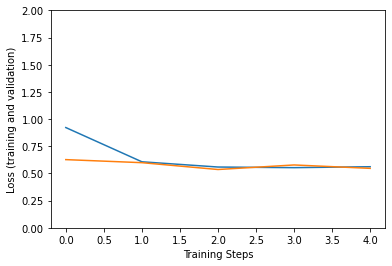

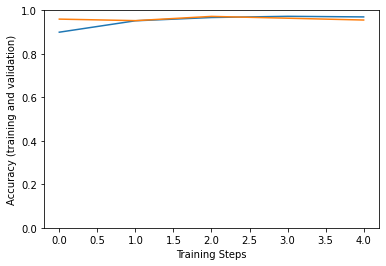

In [10]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

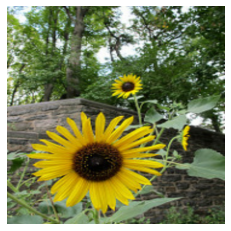

True label: sunflowers
Predicted label: sunflowers


In [11]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

Finally, the trained model can be saved for deployment to TF Serving or TFLite (on mobile) as follows.

In [12]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

2021-11-05 13:09:44.225508: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model_efficientnetv2-xl-21k/assets


## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

In [13]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

2021-11-05 13:10:59.372672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2021-11-05 13:10:59.372728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2021-11-05 13:10:59.372736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.


Wrote TFLite model of 826236388 bytes.


In [14]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [15]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TFLite model agrees with original model on 50 of 50 examples (100%).
TFLite model is accurate on 50 of 50 examples (100%).
